# 駅のホームの混雑状況

駅のホームにカメラを設置して顔検出をすることで、ホームの混雑状況やデータを取ることで時間帯別の混雑時を調べることが出来る。

In [22]:
#インストール
%pip install ultralytics dill opencv-python matplotlib facenet-pytorch mtcnn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


YOLOを使用する。<br>
画像を読み込み、顔を検出する。

検出された顔の数: 34 faces


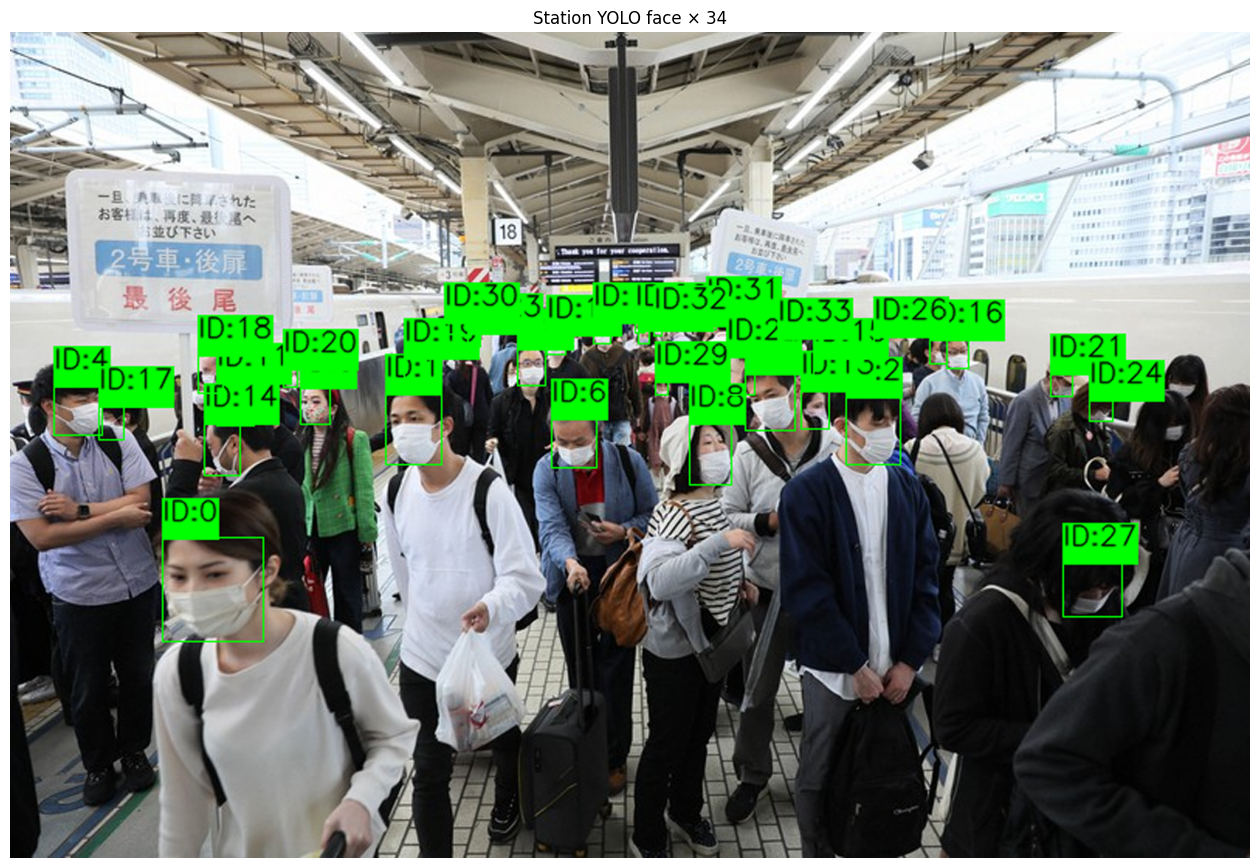

In [23]:
import cv2
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 画像とモデルの準備
image_path = Path("station.jpg")
model_path = Path("yolov8m-face.pt")

# YOLO で高解像度推論
model = YOLO(model_path)
result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

# 画像読み込みと基本情報
annotated = cv2.imread(str(image_path))
h_img, w_img = annotated.shape[:2]

# --- 描画スタイルの設定（ここを小さくしました） ---
color = (0, 255, 0)
font_scale = 0.6  # 文字の大きさ（2から0.6へ）
thickness = 1     # 線の太さ（2から1へ）
pad_ratio = 0.05  # 顔の枠の余白（0.2から0.05へ）

# 検出結果を描画
for idx, box in enumerate(result.boxes.xyxy.cpu().numpy()):
    x1, y1, x2, y2 = map(int, box)
    w = x2 - x1
    h = y2 - y1
    
    # 余白（バッファ）の計算
    pad = int(max(w, h) * pad_ratio)
    x1p = max(0, x1 - pad)
    y1p = max(0, y1 - pad)
    x2p = min(w_img, x2 + pad)
    y2p = min(h_img, y2 + pad)
    
    # 顔を囲む枠を描画
    cv2.rectangle(annotated, (x1p, y1p), (x2p, y2p), color, thickness)
    
    # ラベル（ID:0など）のサイズを取得
    label = f"ID:{idx}"
    (w_label, h_label), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    
    # ラベルを表示する高さの計算（枠の上に被らないように調整）
    y_label = y1p - 5 if y1p - 5 > h_label else y1p + h_label + 5
    
    # ラベルの背景（塗りつぶしの緑の小さな四角）
    cv2.rectangle(annotated, (x1p, y_label - h_label - baseline), (x1p + w_label, y_label + baseline), color, -1)
    
    # ラベルの文字を描画（黒色）
    cv2.putText(annotated, label, (x1p, y_label - baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

# 高解像度で保存
output_path = Path("station_yolo_faces.jpg")
# 保存時のリサイズ（2倍）をやめると、より本来のサイズで確認できます
# 必要に応じて (w_img, h_img) に戻してください
annot_up = cv2.resize(annotated, (w_img * 2, h_img * 2), interpolation=cv2.INTER_CUBIC)
cv2.imwrite(str(output_path), annot_up)

print(f"検出された顔の数: {len(result.boxes)} faces")

# 表示
plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(annot_up, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Station YOLO face × {len(result.boxes)}')
plt.show()


検出した顔を匿名化するためにぼかしをいれる。

ぼかし画像を保存しました: station_yolo_faces_blur_faces.jpg


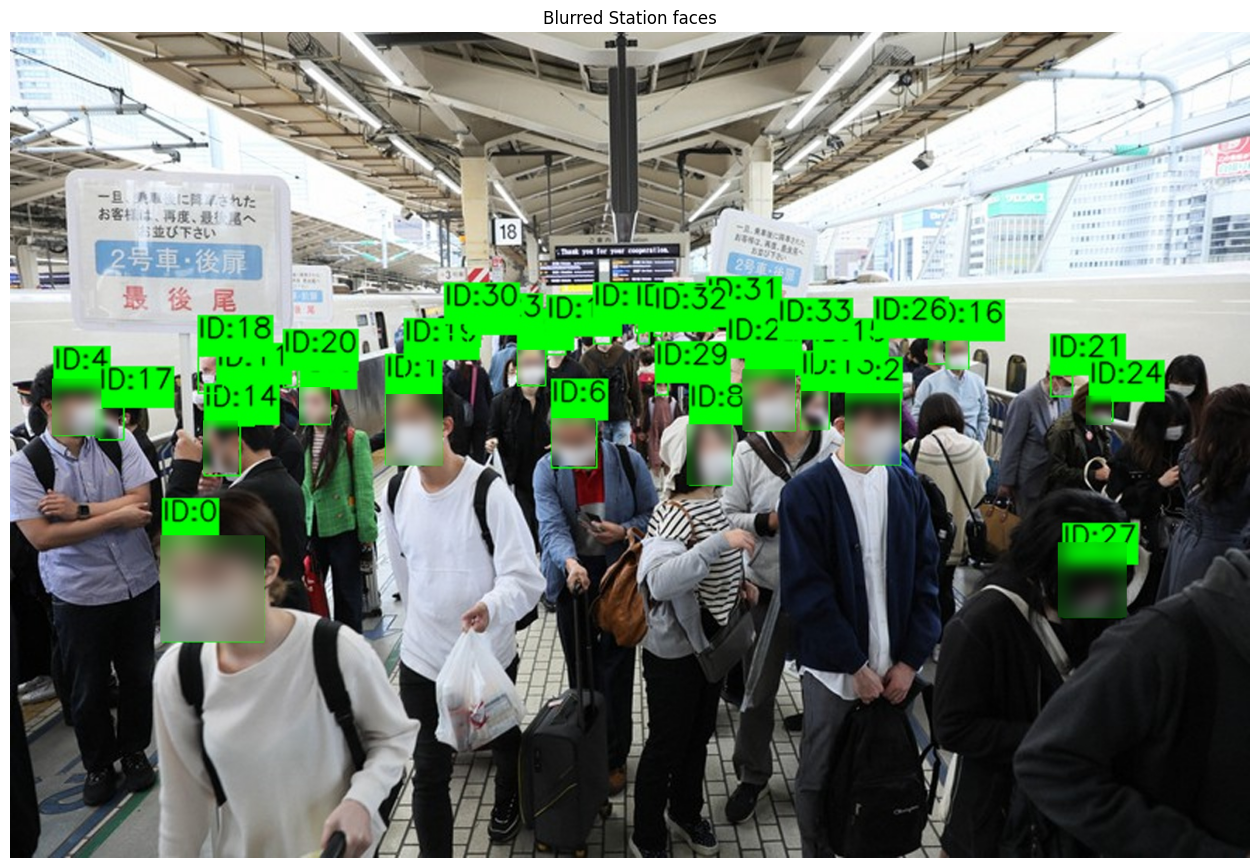

In [24]:
# 顔領域を強くぼかして高解像度で保存（関数化）：blur_faces(image_path) を定義・実行
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def blur_faces(image_path):
    """
    blur_faces(image_path): YOLO で検出して顔領域を強くぼかす関数。
    """
    image_path = Path(image_path)
    model_path = Path('yolov8m-face.pt')
    from ultralytics import YOLO
    model = YOLO(model_path)
    
    # 元の画像（駅の画像など）を読み込む
    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f'Image not found: {image_path}')
    
    h_img, w_img = img.shape[:2]
    # imgszを1280に設定して推論
    result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]
    
    out = img.copy()  # 出力用にコピー

    # 検出された顔ごとに処理
    for box in result.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        if x2 <= x1 or y2 <= y1:
            continue
            
        w = x2 - x1
        h = y2 - y1
        
        # --- 修正箇所：ぼかしの範囲を狭くする ---
        pad_ratio = 0.05  # 0.2 から 0.05（5%）に変更。もっと狭くするなら 0 に。
        pad = int(max(w, h) * pad_ratio) 
        # --------------------------------------
        
        x1p = max(0, x1 - pad)
        y1p = max(0, y1 - pad)
        x2p = min(w_img, x2 + pad)
        y2p = min(h_img, y2 + pad)
        
        face = out[y1p:y2p, x1p:x2p]  # 領域を切り出し
        if face.size == 0:
            continue
            
        # ブラーの強度設定
        k = max(5, min(face.shape[0], face.shape[1]) // 2)
        if k % 2 == 0:
            k += 1
            
        # ガウシアンブラーをかけて貼り付け
        face_blur = cv2.GaussianBlur(face, (k, k), 0)
        face_blur = cv2.GaussianBlur(face_blur, (k, k), 0)
        out[y1p:y2p, x1p:x2p] = face_blur

    # 保存
    output_path = image_path.with_name(image_path.stem + '_blur_faces.jpg')
    # ここではリサイズせず保存（または必要に応じて調整）
    cv2.imwrite(str(output_path), out)
    print(f'ぼかし画像を保存しました: {output_path}')

    # 結果を表示
    plt.figure(figsize=(16,16))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Blurred Station faces')
    plt.show()

# 関数を実行
# ※前回の「緑の枠」がついた画像ではなく、元の画像（station.jpgなど）に対して実行するのがおすすめです。
blur_faces('station_yolo_faces.jpg')

#### 検出結果の分析
顔がしっかり検出できたのは、34人でした。<br>
遠くの人や後ろを向いている人、下を向いている人の顔は検出が難しかったです。

#### 所感
通勤ラッシュや退勤ラッシュ時の時間帯が分かることで通行規制に役立つと思います。また、体調不良者や不審者などの早期発見にも役立つと思います。<br>
今回は静止画で検出を行いましたが、動画を利用して検出することでより質の高いデータを取ることが出来ると思います。<br>
今回のテーマでYOLOの技術が必要だった理由は、高い精度で顔が認識できることと、リアルタイム性です。マスクをしていたり、横を向いていても顔を認識することが出来るのは、混雑している状況に最適な技術だと思いました。また、人の流れが速い場合でもリアルタイムに追跡出来るのが利点だと思いました。